In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
def loadSeries(datatype=None,house=None,rename=None, shifts=None):
    '''
    Loading data series from cf_filled (consumption) or pf_filled (production)
    
    datatype: str, specifies whether the production or consumption values are selected
              
              "Production", "Consumption", "P", "C", "prod", "cons", etc.
    
    
    house: str, specifies which house is selected 
           
           "k28", "h16", "h22", "h28", or "h32"
         
    rename: str, renames chosen column. 
            
            If the whole file is returned, this parameter is ignored
            
    shifts: list of int, if given, specifies what shifted columns to add
    '''
    res = None
    #Production or consumption string stuff
    datatypeStr = ""
    if datatype is None:
        raise Exception("First input must specify either Production or Consumption")
    elif datatype[0].lower()=="p":
        datatypeStr = "prod_"
    elif datatype[0].lower()=="c":
        datatypeStr = "cons_"
    
    #Making sure an existing house is chosen
    if house is None:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    elif house.lower() not in ["k28","h16","h22","h28","h32"]:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    
    #Production or consumption is chosen and loaded
    if datatypeStr=="prod_":
        res = pd.read_csv("pf_filled.csv",sep=",")
        res = res[["Time",datatypeStr+house]]
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    else:
        res = pd.read_csv("cf_filled.csv",sep=",")
        res = res[["Time",datatypeStr+house]]
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    
    #Renaming value column
    if not house is None and not rename is None:
        res = res.rename(columns={datatypeStr+house: rename}, errors="raise")
    
    #Shifted columns added
    if not shifts is None:
        if rename is None:
            shiftname = 't'
        else:
            shiftname = rename
        dataframe = pd.DataFrame()
        for i in shifts:
           dataframe[shiftname + '-' + str(i)] = res.shift(i)
        res = pd.concat([res, dataframe], axis=1)
        res.dropna(inplace=True)
    
    #Nice stuff for indexing
    res['Year']=res.index.year
    res['Month']=res.index.month
    res['Day']=res.index.day
    res['Weekday']=res.index.weekday
    res['Hour']=res.index.hour
    return res

def moving_average(timeseries, window):
    return timeseries.rolling(window=window, center=True).mean()

In [5]:
def merge(house=None,names=["prod","cons"]):
    if house is None:
        raise Exception("First input must specify house: k28, h16, h22, h28, or h32")
    elif house.lower() not in ["k28","h16","h22","h28","h32"]:
        raise Exception("First input must specify house: k28, h16, h22, h28, or h32")
    
    if names is None or len(names)!=2:
        raise Exception("Second input must be a string list of len 2: names=['prod','cons']")
    production = loadSeries("p",house,names[0])['prod']
    consumption = loadSeries("c",house,names[1])['cons']
    merged = pd.merge(production, consumption, how="outer", left_index=True,right_index=True)
    merged["power_yield"] = merged[names[0]] - merged[names[1]]
    return merged
house = "h16"
merged = merge(house)
merged

,prod,cons,power_yield
2020-12-22 00:00:00+00:00,0.0,6.3,-6.3
2020-12-22 01:00:00+00:00,0.0,4.8,-4.8
2020-12-22 02:00:00+00:00,0.0,4.8,-4.8
2020-12-22 03:00:00+00:00,0.0,4.3,-4.3
2020-12-22 04:00:00+00:00,0.0,4.0,-4.0
...,...,...,...
2023-01-10 16:00:00+00:00,0.3,6.1,-5.8
2023-01-10 17:00:00+00:00,0.0,8.3,-8.3
2023-01-10 18:00:00+00:00,0.0,10.4,-10.4
2023-01-10 19:00:00+00:00,0.0,9.9,-9.9


C:\Users\alexa\AppData\Local\Temp\ipykernel_1844\1754142807.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged["cons_ma"] = moving_average(merged["cons"], window=window_size)
C:\Users\alexa\AppData\Local\Temp\ipykernel_1844\1754142807.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged["prod_ma"] = moving_average(merged["prod"], window=window_size)


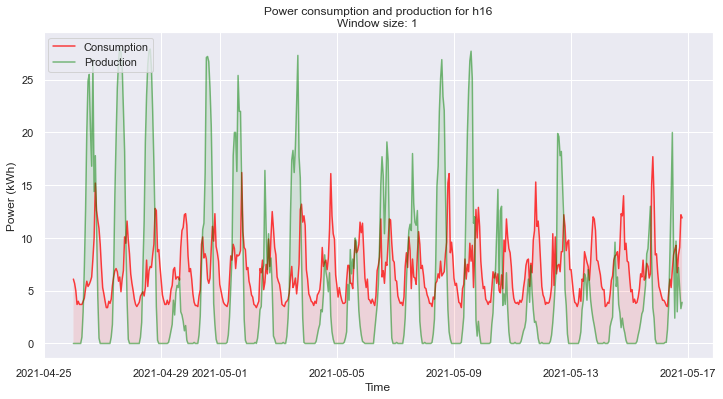

In [13]:
# num_kwh_cons_ma = moving_average(merged["cons"], window=24)
temp = merged
merged = merged[3000:3500]

window_size = 1

merged["cons_ma"] = moving_average(merged["cons"], window=window_size)
merged["prod_ma"] = moving_average(merged["prod"], window=window_size)

sns.set()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(merged.index, merged["cons_ma"], label="Consumption", color="red", alpha=0.75)
ax.plot(merged.index, merged["prod_ma"], label="Production", color="green", alpha=0.5)
# ax.plot(series_battery["timeslot"], series_battery["surplus_deficit"], label="Surplus Deficit", alpha=0.75)
# show legend
ax.legend(loc="upper left")

# Fill between positive
# ax.fill_between(merged.index, 0, series_merge["cons"], where=series_merge["cons"] >= 0, facecolor="green", alpha=0.5)
ax.fill_between(merged.index, merged["cons_ma"], merged["prod_ma"], where=merged["prod_ma"]>merged["cons_ma"], facecolor='green', alpha=0.1)
ax.fill_between(merged.index, merged["cons_ma"], merged["prod_ma"], where=merged["prod_ma"]<merged["cons_ma"], facecolor='red', alpha=0.1)

# x-axis label
ax.set_xlabel("Time")
# y-axis label
ax.set_ylabel("Power (kWh)")

# plot title    
ax.set_title("Power consumption and production for " + house + "\nWindow size: " + str(window_size))

plt.savefig("ProdConsPlot.png")

plt.show()
merged = temp

In [ ]:
temp = merged[merged["power_yield"] > 0].sum()

temp/merged['prod'].sum()